In [117]:
import os
import json
import numpy as np
import pandas as pd
from math import sqrt
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler

In [173]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [174]:

'''
for each file containing VM memory state, we store data into a dict object called df
'''
list_of_files = []
dir_data = "data2"
for file in os.listdir(dir_data):
    if file.endswith(".csv") and file != "dataset.csv":
        list_of_files.append(os.path.join(dir_data,file)) #add file name to list of file name

df={}
for name in list_of_files:
    data = np.loadtxt(name,delimiter=",",skiprows=1) #load data, we skip first row that contains name of variables
    df[name] = {"time":data[:,0],"limit_cgroup":data[:,1],"vm_view_mem_total":data[:,2],"vm_view_mem_available":data[:,3],"vm_view_memory_used":data[:,4],"host_view_vm_memory_used":data[:,5],"host_view_vm_current_swap":data[:,6],"vm2_view_response_time":data[:,7],"icmp_response_time":data[:,8],"bw_down":data[:,9],"bw_up":data[:,10]}
    #print(df[name])

In [175]:
X =  {"limit_cgroup":[],"vm_view_mem_total":[],"vm_view_mem_available":[],"vm_view_memory_used":[],"host_view_vm_memory_used":[],"host_view_vm_current_swap":[],"vm2_view_response_time":[],"icmp_response_time":[],"bw_down":[],"bw_up":[]}
for key in df.keys():
    for metric in X.keys():
        X[metric].extend(df[key][metric])

In [176]:
def create_time_series(data, window_size):
    time_series = []
    data_size = len(data)

    for i in range(data_size - window_size + 1):
        window = data[i:i + window_size]
        time_series.append(window)

    return time_series


In [179]:
def process_data_from_df(df,n_future,n_past,show_plot=True,):
    
    def cut_df_in_windows(x_scaled):
        x_ = []
        y_ = []   


        for i in range(n_past,len(x_scaled)-n_future+1):
            
            response_time = x_scaled[i-n_past:i,x_scaled.shape[1]-4]
            #This is a way of getting a window of past observations that will be used to predict future one 
            features = x_scaled[i - n_past:i, np.r_[:7, 8:x_scaled.shape[1]]]
            #creating a window of n_past past observations.
            x_.append(features)   
            y_.append(x_scaled[i+n_future-1:i+n_future,x_scaled.shape[1]-4]) #Chaque élément ajouté à y_ est le temps de réponse correspondant
                                                                            # à la dernière observation de la fenêtre temporelle actuelle            
            
        x_ = np.array(x_)
        print(len(x_),)
        y_ = np.array(y_)
    
        #print("x_ shape : {} - y_ shape : {}".format(x_.shape,y_.shape))
        print("x est ", x_)
        print("y est :", y_)
        return x_,y_
    
    x = pd.DataFrame(df,dtype=np.float64)
    dataset = x
    cols = list(x)[0:]
    df_x = x[cols].astype(float)
    
    df_x["limit_cgroup"] = df_x["limit_cgroup"].apply(lambda x: x/1024**2)
    df_x["vm_view_mem_total"] = df_x["vm_view_mem_total"].apply(lambda x: x/1024**2)
    df_x["vm_view_mem_available"] = df_x["vm_view_mem_available"].apply(lambda x: x/1024**2)
    df_x["vm_view_memory_used"] = df_x["vm_view_memory_used"].apply(lambda x: x/1048576)
    df_x["host_view_vm_memory_used"] = df_x["host_view_vm_memory_used"].apply(lambda x: x/1024**2)
    df_x["host_view_vm_current_swap"] = df_x["host_view_vm_current_swap"].apply(lambda x: x/1024**2)
    df_x["bw_up"] = df_x["bw_up"].apply(lambda x: x*1024*2)
    df_x["vm2_view_response_time"]=df_x["vm2_view_response_time"].apply(lambda x: x*10)

    if show_plot:
        df_x.iloc[:, [i for i in range(df_x.shape[1]) if i not in [9,6]]].plot()
        df_x["vm2_view_response_time"].plot(label='vm2_view_response_time')
        df_x["bw_up"].plot(label='bw_up')
        plt.legend()

# Affichage du graphique
        plt.show()
        
        #df_x["bw_down"].plot()

        
    x_to_be_cut = []
    scaler = StandardScaler()
        
    if SCALER:
        
        x_scaled = scaler.fit(df_x)
        x_scaled = scaler.transform(df_x)
        x_to_be_cut = x_scaled
        
        
    else :
        x_to_be_cut = df_x.to_numpy()


    #print(x_to_be_cut.shape)
    x_,y_ = cut_df_in_windows(x_to_be_cut)
    return dataset,x_,y_,scaler

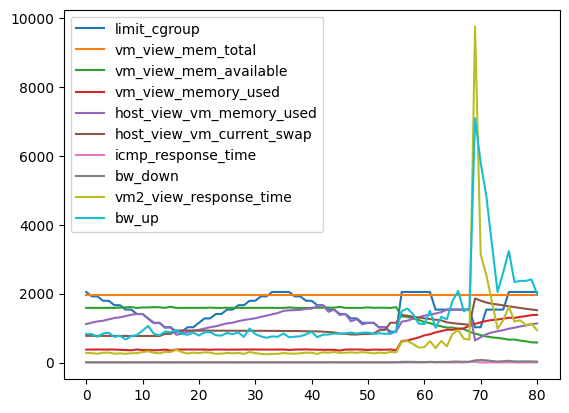

75
x est  [[[2048.         1962.77734375 1588.56640625 ...  278.2675
      7.32058525  830.33007812]
  [1920.         1962.77734375 1586.5390625  ...  273.5825
      7.2817924   823.25634766]
  [1920.         1962.77734375 1584.86328125 ...  253.87
      7.53572893  746.87939453]
  [1792.         1962.77734375 1586.12109375 ...  284.0625
      7.55331254  843.09570312]
  [1792.         1962.77734375 1587.13671875 ...  288.1675
      7.37232542  864.77148438]]

 [[1920.         1962.77734375 1586.5390625  ...  273.5825
      7.2817924   823.25634766]
  [1920.         1962.77734375 1584.86328125 ...  253.87
      7.53572893  746.87939453]
  [1792.         1962.77734375 1586.12109375 ...  284.0625
      7.55331254  843.09570312]
  [1792.         1962.77734375 1587.13671875 ...  288.1675
      7.37232542  864.77148438]
  [1664.         1962.77734375 1585.8359375  ...  255.6125
      7.61247969  744.        ]]

 [[1920.         1962.77734375 1584.86328125 ...  253.87
      7.53572893  746.8

In [181]:
SCALER = False

n_future = 2
n_past =5
x,x_,y_,scaler = process_data_from_df(X,n_future,n_past)
x.to_csv("dataset3.csv",index=False)

In [182]:
#On sépare le dataset en donnée d'entrainement et de test. 
# 20% -> test
# 80% -> entrainement
x_train = x_[:int(x_.shape[0]*0.8)]
y_train = y_[:int(x_.shape[0]*0.8)]

x_val = x_[int(x_.shape[0]*0.7):int(x_.shape[0]*0.8)]
y_val = y_[int(x_.shape[0]*0.7):int(x_.shape[0]*0.8)]
x_test = x_[int(x_.shape[0]*0.8):]
y_test = y_[int(x_.shape[0]*0.8):]



In [183]:
x_save,y_save = x_,y_

In [184]:
size_lstm_1,size_lstm_2 = 64,32
def lstm_model():
    
    inputs = layers.Input(shape=(x_train.shape[1],x_train.shape[2]), name="input")
    lstm_1 = layers.LSTM(size_lstm_1, activation="relu",return_sequences=True,name="lstm_layer_1")(inputs)
    lstm_2 = layers.LSTM(size_lstm_2, activation="relu",return_sequences=False,name="lstm_layer_2")(lstm_1)
    dropout = layers.Dropout(0.2)(lstm_2) #chaque neurone a une proba de 0.2 d’être désactivé.
    output = layers.Dense(y_train.shape[1])(dropout)
    
    model = Model(inputs,output)
    
    return model

In [185]:
my_model = lstm_model()

In [186]:
my_model.compile(optimizer="adam",loss="mse")     #When training a deep learning model, you must adapt every epoch's weight and minimize the loss function. An optimizer is an algorithm or function that adapts the neural network's attributes, like learning rate and weights
#Mean Squared Error (MSE) as the loss function. For regression problems, MSE is commonly used as it measures the average squared difference between the predicted values and the actual values
my_model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 5, 9)]            0         
                                                                 
 lstm_layer_1 (LSTM)         (None, 5, 64)             18944     
                                                                 
 lstm_layer_2 (LSTM)         (None, 32)                12416     
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 31393 (122.63 KB)
Trainable params: 31393 (122.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [187]:
history = my_model.fit(x_train,y_train,validation_split=0.1,epochs=10,batch_size=64,
                       verbose=1)

Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 70240.7812 - val_loss: 128968.1641
Epoch 2/10
1/1 [==============================] - 0s 73ms/step - loss: 49244.5938 - val_loss: 38360.7031
Epoch 3/10
1/1 [==============================] - 0s 55ms/step - loss: 33747.9414 - val_loss: 24875.5879
Epoch 4/10
1/1 [==============================] - 0s 64ms/step - loss: 24569.5000 - val_loss: 121859.5703
Epoch 5/10
1/1 [==============================] - 0s 63ms/step - loss: 27080.7168 - val_loss: 112681.0859
Epoch 6/10
1/1 [==============================] - 0s 62ms/step - loss: 28426.7656 - val_loss: 112600.3125
Epoch 7/10
1/1 [==============================] - 0s 66ms/step - loss: 30130.9219 - val_loss: 116541.0938
Epoch 8/10
1/1 [==============================] - 0s 61ms/step - loss: 30925.1035 - val_loss: 59103.2656
Epoch 9/10
1/1 [==============================] - 0s 64ms/step - loss: 24330.9883 - val_loss: 86770.8359
Epoch 10/10
1/1 [==============================] - 0

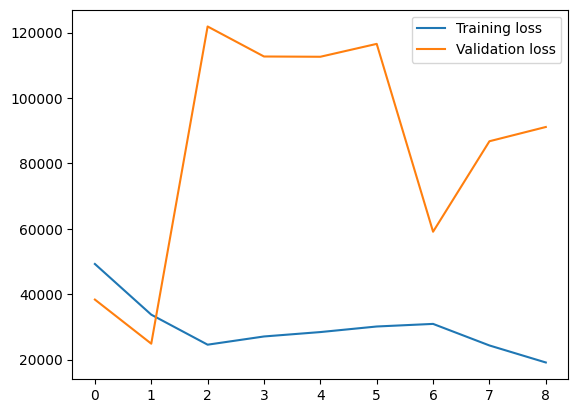

In [188]:
plt.plot(history.history['loss'][1:], label='Training loss')
plt.plot(history.history['val_loss'][1:], label='Validation loss')
plt.legend()
plt.show()

In [143]:
y_pred_tot = my_model.predict(x_save)
if SCALER:

    prediction_copies = np.repeat(prediction, features, axis=-1)
    y_pred_tot = scaler.inverse_transform(prediction_copies)[:,6]


    y_expected_copies = np.repeat(y_save, features, axis=-1)
    y_save = scaler.inverse_transform(y_expected_copies)[:,6]

3/3 [==============================] - 0s 5ms/step


In [144]:
y_pred_tot.shape,y_save.shape

((75, 1), (75, 1))

In [145]:
mean_squared_error(y_pred_tot,y_save)

1765268.5048634133

29
x est  [[[2048.         1962.77734375 1588.56640625 ...  278.2675
      7.32058525  830.33007812]
  [1920.         1962.77734375 1586.5390625  ...  273.5825
      7.2817924   823.25634766]
  [1920.         1962.77734375 1584.86328125 ...  253.87
      7.53572893  746.87939453]
  [1792.         1962.77734375 1586.12109375 ...  284.0625
      7.55331254  843.09570312]
  [1792.         1962.77734375 1587.13671875 ...  288.1675
      7.37232542  864.77148438]]

 [[1920.         1962.77734375 1586.5390625  ...  273.5825
      7.2817924   823.25634766]
  [1920.         1962.77734375 1584.86328125 ...  253.87
      7.53572893  746.87939453]
  [1792.         1962.77734375 1586.12109375 ...  284.0625
      7.55331254  843.09570312]
  [1792.         1962.77734375 1587.13671875 ...  288.1675
      7.37232542  864.77148438]
  [1664.         1962.77734375 1585.8359375  ...  255.6125
      7.61247969  744.        ]]

 [[1920.         1962.77734375 1584.86328125 ...  253.87
      7.53572893  746.8

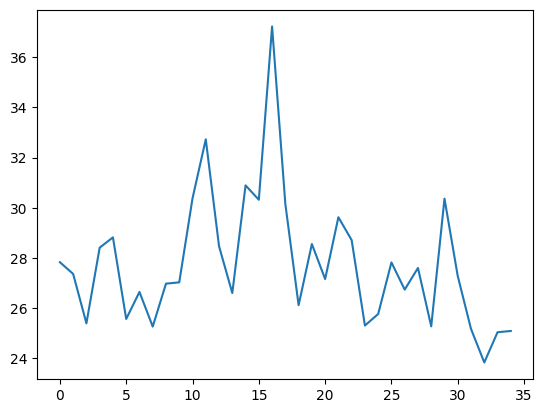

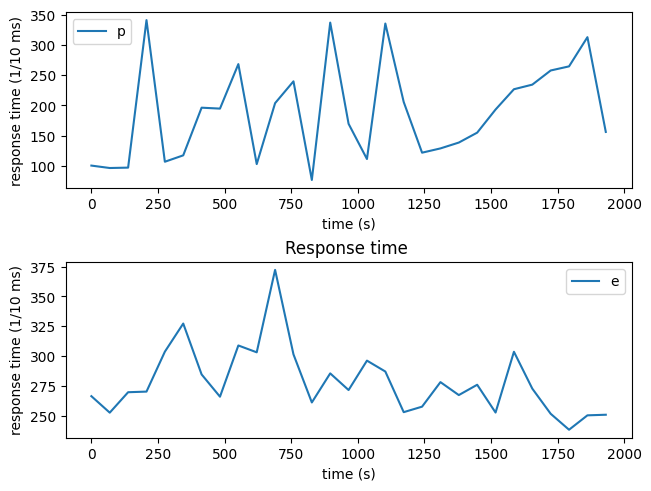

15
x est  [[[2048.         1962.77734375 1584.76953125  378.0078125  1498.984375
    915.41796875  275.9225        7.59496152  844.10351562]
  [2048.         1962.77734375 1598.3984375   364.37890625 1515.42578125
    914.421875    260.39          6.98053837  733.68676758]
  [1920.         1962.77734375 1586.8359375   375.94140625 1521.046875
    913.921875    256.48125       7.06975269  749.55761719]
  [1920.         1962.77734375 1584.83203125  377.9453125  1528.84375
    912.421875    267.6425        7.35602701  761.08569336]
  [1792.         1962.77734375 1581.94140625  380.8359375  1556.11328125
    906.1796875   285.47142857    7.87071501  815.52427455]]

 [[2048.         1962.77734375 1598.3984375   364.37890625 1515.42578125
    914.421875    260.39          6.98053837  733.68676758]
  [1920.         1962.77734375 1586.8359375   375.94140625 1521.046875
    913.921875    256.48125       7.06975269  749.55761719]
  [1920.         1962.77734375 1584.83203125  377.9453125  1528.84

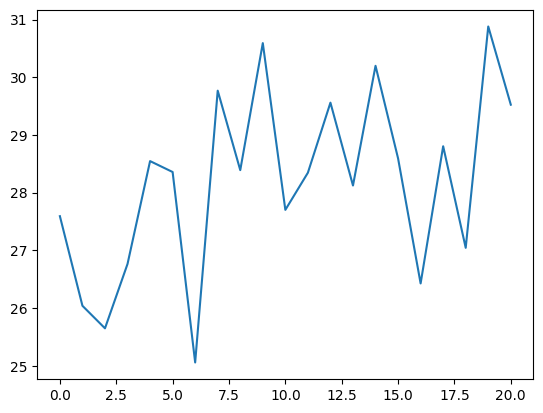

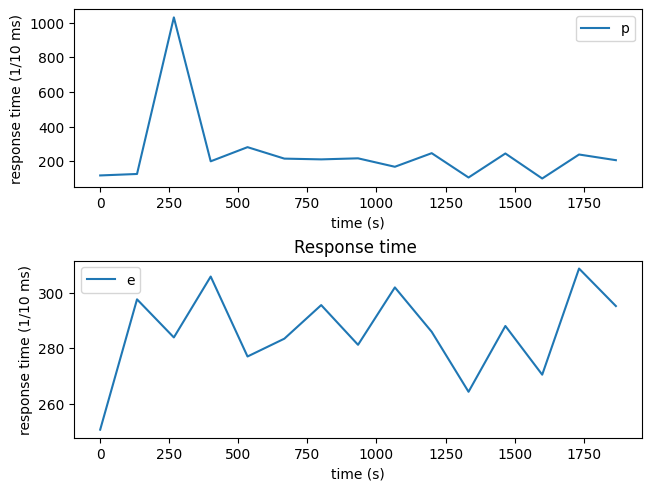

19
x est  [[[2048.         1962.77734375 1339.5390625   623.23828125 1185.65234375
   1378.41015625  600.67         18.03203964 1492.97949219]
  [2048.         1962.77734375 1324.56640625  638.2109375  1215.72265625
   1359.41015625  623.14         19.66473389 1568.34375   ]
  [2048.         1962.77734375 1278.8828125   683.89453125 1270.04296875
   1328.66015625  536.715        17.71300745 1402.2734375 ]
  [2048.         1962.77734375 1235.078125    727.69921875 1310.30078125
   1306.16015625  433.685        13.47332287 1129.72851562]
  [2048.         1962.77734375 1175.0390625   787.73828125 1360.3828125
   1283.16015625  444.915        12.4898448  1113.52636719]]

 [[2048.         1962.77734375 1324.56640625  638.2109375  1215.72265625
   1359.41015625  623.14         19.66473389 1568.34375   ]
  [2048.         1962.77734375 1278.8828125   683.89453125 1270.04296875
   1328.66015625  536.715        17.71300745 1402.2734375 ]
  [2048.         1962.77734375 1235.078125    727.69921875

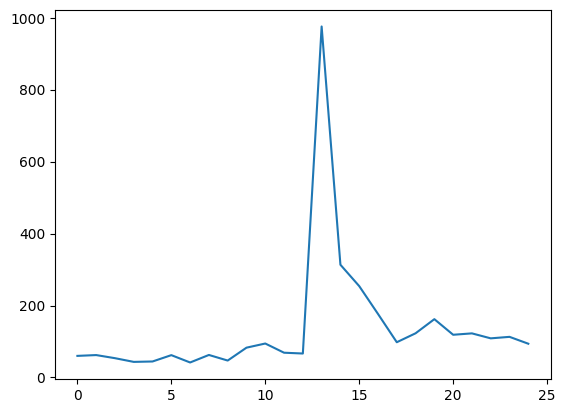

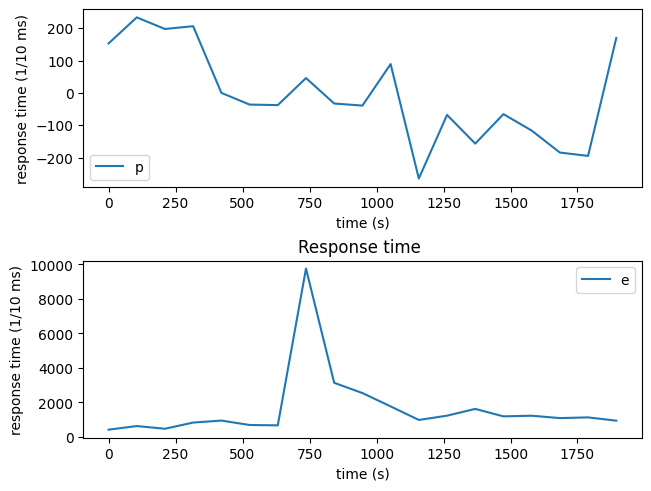

In [159]:
for dataset in df.keys():
    
    
    df_curr = df[dataset].copy()
    
    df_test = pd.DataFrame(df_curr,dtype=float)
    df_test["vm_view_response_time"].plot()
    
    df_curr.pop("time",None)
    
    
    d,x_,y_,scaler_bis = process_data_from_df(df_curr,n_future,n_past,show_plot=False)
    
    
    print(x_.shape)
    y_pred = my_model.predict(x_)
    print(len(y_), len(y_pred))

    print("mse = {}".format(mean_squared_error(y_pred,y_)))
    
    if SCALER:
        y_pred_copies = np.repeat(y_pred, 6, axis=-1)
        y_pred = scaler_bis.inverse_transform(y_pred_copies)[0]
   
    
        y_expected = np.repeat(y_, n_past, axis=-1)
        y_ = scaler_bis.inverse_transform(y_)[0]

    
    n_y_pred = len(y_pred)+n_past+n_past_response_time
    
    y_label = [y*(2000/len(y_pred)) for y in range(len(y_pred))]
    
    #y_pred = np.insert(y_pred,0,[0 for y in range(n_past+n_past_response_time)])    #ensure that the plot starts at time 0 and includes the past values required for making predictions
    #y_ = np.insert(y_,0,[0 for y in range(n_past+n_past_response_time)])
    #print(y_pred,y_)
    
    print(len(y_), len(y_pred))
    
    fig, (ax1, ax2) = plt.subplots(2, 1, constrained_layout=True)
    ax1.plot(y_label,y_pred)
    ax1.set_xlabel("time (s)")
    ax1.set_ylabel("response time (1/10 ms)")
    ax1.set_facecolor('w')
    ax1.legend("prediction")
    #ax1.set_ylim(0,12000)
    #ax1.set_title("Predicted outputs")
    
    
    ax2.plot(y_label,y_)
    ax2.set_xlabel("time (s)")
    ax2.set_ylabel("response time (1/10 ms)")
    ax2.set_facecolor('w')
    ax2.legend("expected")
    #ax2.set_ylim(0,12000)
    
    #ax2.set_title("Expected outputs")
    
    file_name = dataset.split("\\")[1].split(".")[0]
    #reduction = file_name[5]
    ##num_experience = file_name[6]
    
    plt.title("Response time ")
    #plt.text("experience num:"+num_experience,0,400)
    
    
    fig.savefig("plot-result/"+file_name+".jpg",transparent=False)
    plt.show()
    